# Figures

Reproducing the `GQA-paper` figures as described in the `ReadMe.md`.

In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from collections import Counter
import argparse
from tqdm import tqdm
from scipy.special import rel_entr
import plotly.express as px
import matplotlib.pyplot as plt

## Loading GQA

It takes quiet some time to execute the next cell (on my machine 17min):

In [2]:
gqa_data_path = Path('ver1.2/')

# balanced questions
gqa_train_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('train_' + 'balanced_' + 'questions.json'))))).T
gqa_val_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('val_' + 'balanced_' + 'questions.json'))))).T
gqa_testdev_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('testdev_' + 'balanced_' + 'questions.json'))))).T

gqa_testdev_balanced_questions_test = json.load(open(Path(gqa_data_path / ('testdev_' + 'balanced_' + 'questions.json'))))

# all questions
gqa_train_all_questions_file_paths = [file for file in Path(gqa_data_path / 'train_all_questions').glob('*.json')]
gqa_train_all_questions = pd.DataFrame(json.load(open(gqa_train_all_questions_file_paths[0]))).T
for file in gqa_train_all_questions_file_paths[1:]:
    gqa_train_all_questions = pd.concat([gqa_train_all_questions, pd.DataFrame(json.load(open(file))).T])
gqa_val_all_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('val_' + 'all_' + 'questions.json'))))).T
gqa_testdev_all_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('testdev_' + 'all_' + 'questions.json'))))).T

gqa_val_all_questions_test = json.load(open(Path(gqa_data_path / ('val_' + 'all_' + 'questions.json'))))

Now concat all the dataframes with the relevant columns, and compute the question length and the semantic composition length.

In [3]:
gqa_train_balanced_questions['datasplit'] = 'train'
gqa_val_balanced_questions['datasplit'] = 'val'
gqa_testdev_balanced_questions['datasplit'] = 'testdev'

gqa_train_all_questions['datasplit'] = 'train'
gqa_val_all_questions['datasplit'] = 'val'
gqa_testdev_all_questions['datasplit'] = 'testdev'

In [4]:
# for balanced:
gqa_questions_balanced_raw = pd.concat([gqa_train_balanced_questions,
                                        gqa_val_balanced_questions,
                                        gqa_testdev_balanced_questions])[['question', 'answer', 'types', 'semantic', 'datasplit', 'groups']]

questionIDs_balanced = list(gqa_questions_balanced_raw.index)
gqa_questions_balanced = pd.DataFrame(columns=['questionID', 'question_text', 'answer_text',
                                               'semantic_type', 'structural_type', 'detailed_type', 'datasplit',
                                               'global_question_group', 'local_question_group', 'local_question_group_clean',
                                               'question_length', 'composition_len_semantic'],
                                      index = questionIDs_balanced)

gqa_questions_balanced.loc[slice(None),'questionID'] = gqa_questions_balanced_raw.index.values
gqa_questions_balanced.loc[slice(None),'question_text'] = gqa_questions_balanced_raw['question']
gqa_questions_balanced.loc[slice(None),'answer_text'] = gqa_questions_balanced_raw['answer']
gqa_questions_balanced.loc[slice(None),'semantic_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['semantic'])
gqa_questions_balanced.loc[slice(None),'structural_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['structural'])
gqa_questions_balanced.loc[slice(None),'detailed_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['detailed'])
gqa_questions_balanced.loc[slice(None),'datasplit'] = gqa_questions_balanced_raw['datasplit']

# get balancing stuff
gqa_questions_balanced.loc[slice(None),'global_question_group'] = gqa_questions_balanced_raw['groups'].apply(lambda x: x['global'])
gqa_questions_balanced.loc[slice(None),'local_question_group'] = gqa_questions_balanced_raw['groups'].apply(lambda x: x['local'])

# clean the answer type to fit the paper
gqa_questions_balanced.loc[slice(None),'local_question_group_clean'] = gqa_questions_balanced_raw['groups'].apply(lambda x: x['local'].split('-')[-1].split(',')[0] if type(x['local']) is str else None)

# compute statistics
gqa_questions_balanced.loc[slice(None),'question_length'] = gqa_questions_balanced_raw['question'].apply(lambda x: len(re.findall(r'\w+', x)))
gqa_questions_balanced.loc[slice(None),'composition_len_semantic'] = gqa_questions_balanced_raw['semantic'].apply(lambda x: len(x))

In [5]:
# for all:
gqa_questions_all_raw = pd.concat([gqa_train_all_questions,
                                   gqa_val_all_questions,
                                   gqa_testdev_all_questions])[['question', 'answer', 'types', 'semantic', 'datasplit', 'groups']]

questionIDs_all = list(gqa_questions_all_raw.index)
gqa_questions_all = pd.DataFrame(columns=['questionID', 'question_text', 'answer_text',
                                          'semantic_type', 'structural_type', 'detailed_type', 'datasplit',
                                          'global_question_group', 'local_question_group', 'local_question_group_clean',
                                          'question_length', 'composition_len_semantic'],
                                 index = questionIDs_all)

gqa_questions_all.loc[slice(None),'questionID'] = gqa_questions_all_raw.index.values
gqa_questions_all.loc[slice(None),'question_text'] = gqa_questions_all_raw['question']
gqa_questions_all.loc[slice(None),'answer_text'] = gqa_questions_all_raw['answer']
gqa_questions_all.loc[slice(None),'semantic_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['semantic'])
gqa_questions_all.loc[slice(None),'structural_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['structural'])
gqa_questions_all.loc[slice(None),'detailed_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['detailed'])
gqa_questions_all.loc[slice(None),'datasplit'] = gqa_questions_all_raw['datasplit']

# get balancing stuff
gqa_questions_all.loc[slice(None),'global_question_group'] = gqa_questions_all_raw['groups'].apply(lambda x: x['global'])
gqa_questions_all.loc[slice(None),'local_question_group'] = gqa_questions_all_raw['groups'].apply(lambda x: x['local'])

# clean the answer type to fit the paper
gqa_questions_all.loc[slice(None),'local_question_group_clean'] = gqa_questions_all_raw['groups'].apply(lambda x: x['local'].split('-')[-1].split(',')[0] if type(x['local']) is str else None)

# compute statistics
gqa_questions_all.loc[slice(None),'question_length'] = gqa_questions_all_raw['question'].apply(lambda x: len(re.findall(r'\w+', x)))
gqa_questions_all.loc[slice(None),'composition_len_semantic'] = gqa_questions_all_raw['semantic'].apply(lambda x: len(x))

In [6]:
gqa_questions_balanced

questionID                          question_text answer_text  \
02930152    02930152                       Is the sky dark?         yes   
07333408    07333408             What is on the white wall?        pipe   
07333405    07333405                      Is that pipe red?          no   
15736264    15736264      Is the tall clock small or large?       large   
111007521  111007521                Who is wearing a shirt?        girl   
...              ...                                    ...         ...   
20341099    20341099  Is there a fire hydrant on the grass?         yes   
20341098    20341098             Where is the fire hydrant?       grass   
20341097    20341097            Where is that fire hydrant?       grass   
20602949    20602949      What is the horse running across?      ground   
201738903  201738903                        Who is staring?  spectators   

          semantic_type structural_type detailed_type datasplit  \
02930152           attr          verify    verifyAttr     train   
07333408            rel           query          relS     train   
07333405           attr          verify   verifyAttrC     train   
15736264           attr          choose    chooseAttr     train   
111007521           rel           query          relS     train   
...                 ...             ...           ...       ...   
20341099            rel          verify     existRelS   testdev   
20341098            rel           query          relO   testdev   
20341097            rel           query          relO   testdev   
20602949            rel           query          relO   testdev   
201738903           cat           query   activityWho   testdev   

          global_question_group       local_question_group  \
02930152                   None                06-sky_dark   
07333408                                      14-wall_on,s   
07333405                   None                06-pipe_red   
15736264                   size             10c-clock_size   
111007521                person         14-shirt_wearing,s   
...                         ...                        ...   
20341099                   None      13-grass_fire hydrant   
20341098                  plant       14-fire hydrant_on,o   
20341097                  plant       14-fire hydrant_on,o   
20602949     nature environment  14-horse_running across,o   
201738903                person                    staring   

          local_question_group_clean question_length composition_len_semantic  
02930152                    sky_dark               4                        2  
07333408                     wall_on               6                        4  
07333405                    pipe_red               4                        2  
15736264                  clock_size               7                        3  
111007521              shirt_wearing               5                        3  
...                              ...             ...                      ...  
20341099          grass_fire hydrant               8                        3  
20341098             fire hydrant_on               5                        3  
20341097             fire hydrant_on               5                        3  
20602949        horse_running across               6                        3  
201738903                    staring               3                        3  

[1087640 rows x 12 columns]

### Testing the loading

In [7]:
seed = 42

# sample a key from testdev for balanced questions
np.random.seed(seed)
testdev_keys = list(gqa_testdev_balanced_questions_test.keys())
testdev_key = np.random.choice(testdev_keys)

# sample a key from val for all questions
np.random.seed(seed)
val_keys = list(gqa_val_all_questions_test.keys())
val_key = np.random.choice(val_keys)

In [8]:
# balanced
print(f"quid: {testdev_key}")
for key, value in gqa_testdev_balanced_questions_test[testdev_key].items():
    if key == 'semantic':
        for item_ in value:
            print(item_)
    else:
        print(f"{key}: \t {value}")
print("-------------------")
print("How it was loaded:")
gqa_questions_balanced.loc[testdev_key]

quid: 201411119
{'operation': 'select', 'dependencies': [], 'argument': 'clothing (5)'}
{'operation': 'filter color', 'dependencies': [0], 'argument': 'white'}
{'operation': 'query', 'dependencies': [1], 'argument': 'name'}
entailed: 	 ['201411117']
equivalent: 	 ['201411119']
question: 	 Which kind of clothing is white?
imageId: 	 n415215
isBalanced: 	 True
groups: 	 {'global': 'clothing', 'local': '12q-clothing_white'}
answer: 	 shirt
semanticStr: 	 select: clothing (5)->filter color: white [0]->query: name [1]
annotations: 	 {'answer': {'0': '5'}, 'question': {'3': '5'}, 'fullAnswer': {'1': '5', '4': '5'}}
types: 	 {'detailed': 'categoryThat', 'semantic': 'cat', 'structural': 'query'}
fullAnswer: 	 The clothing is a shirt.
-------------------
How it was loaded:


questionID                                           201411119
question_text                 Which kind of clothing is white?
answer_text                                              shirt
semantic_type                                              cat
structural_type                                          query
detailed_type                                     categoryThat
datasplit                                              testdev
global_question_group                                 clothing
local_question_group                        12q-clothing_white
local_question_group_clean                      clothing_white
question_length                                              6
composition_len_semantic                                     3
Name: 201411119, dtype: object

In [9]:
# all
print(f"quid: {val_key}")
for key, value in gqa_val_all_questions_test[val_key].items():
    if key == 'semantic':
        for item_ in value:
            print(item_)
    else:
        print(f"{key}: \t {value}")
print("-------------------")
print("How it was loaded:")
gqa_questions_all.loc[val_key]

quid: 001058327
{'operation': 'select', 'dependencies': [], 'argument': 'bear (1341489)'}
{'operation': 'exist', 'dependencies': [0], 'argument': '?'}
{'operation': 'select', 'dependencies': [], 'argument': 'goat (-) '}
{'operation': 'exist', 'dependencies': [2], 'argument': '?'}
{'operation': 'and', 'dependencies': [1, 3], 'argument': ''}
entailed: 	 ['001058328', '001058329', '001058326']
equivalent: 	 ['001058326', '001058329', '001058327', '001058328']
question: 	 Do you see both bears and goats in the picture?
imageId: 	 2380873
isBalanced: 	 False
groups: 	 {'global': None, 'local': '09existAnd-bear_goat'}
answer: 	 no
semanticStr: 	 select: bear (1341489)->exist: ? [0]->select: goat (-) ->exist: ? [2]->and:  [1, 3]
annotations: 	 {'answer': {}, 'question': {'4': '1341489'}, 'fullAnswer': {'4': '1341489'}}
types: 	 {'detailed': 'existAndC', 'semantic': 'obj', 'structural': 'logical'}
fullAnswer: 	 No, there is a bear but no goats.
-------------------
How it was loaded:


questionID                                                          001058327
question_text                 Do you see both bears and goats in the picture?
answer_text                                                                no
semantic_type                                                             obj
structural_type                                                       logical
detailed_type                                                       existAndC
datasplit                                                                 val
global_question_group                                                    None
local_question_group                                     09existAnd-bear_goat
local_question_group_clean                                          bear_goat
question_length                                                            10
composition_len_semantic                                                    5
Name: 001058327, dtype: object

## Reproducing figure 7: First Question Words (ReadMe: 1.)

To reduce the elements which need to be plotted, I introduce a cutoff of 0.1% of the total number questions for each word to be plotted. If it is below the cutoff, an `null` is plotted. This is not perfect, but suffices.

In [10]:
# create a dataframe for the sunburst diagram: first words, then their corresponding value up to a cut-off
# the cut-off is 0.1% of the total number of questions

# extract the first four words from the question_text
gqa_questions_balanced['first_four_words'] = gqa_questions_balanced['question_text'].str.split().apply(lambda x: ' '.join(x[:4]))

# count occurences
word_counts = gqa_questions_balanced['first_four_words'].value_counts().reset_index()
word_counts.columns = ['first_four_words', 'count']

word_counts

first_four_words  count
0            On which side of  26448
1           What color is the  20508
2              What is on the  16206
3            On which side is  13730
4              Do you see any  13531
...                       ...    ...
64038       Is the luggage of      1
64039     The device the lady      1
64040       Is the metal drum      1
64041  Are there both serving      1
64042  Is the sidewalk narrow      1

[64043 rows x 2 columns]

In [13]:
# create a new dataframe with the necessary info
sunburst_df = pd.DataFrame(columns=['first_words', 'second_words', 'third_words', 'fourth_words', 'count'])

print(f"The minimum length of the questions is {gqa_questions_balanced['question_length'].min()} and the maximum length is {gqa_questions_balanced['question_length'].max()}")

# split the question into its words
sunburst_df['first_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[0])
sunburst_df['second_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[1])
sunburst_df['third_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[2])
sunburst_df['fourth_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[3] if len(x.split()) >= 4  else "")

# remove the question mark for the third_word and the forth_word
sunburst_df['third_words'] = sunburst_df['third_words'].apply(lambda x: x[:-1] if x[-1] == '?' else x)
sunburst_df['fourth_words'] = sunburst_df['fourth_words'].apply(lambda x: x[:-1] if x != "" and x[-1] == '?' else x)

sunburst_df['count'] = word_counts['count']

print(f"Check: The sunburst diagram dataframe has {sunburst_df.shape[0]} entries with a count sum of {sunburst_df['count'].sum()}")

The minimum length of the questions is 3 and the maximum length is 28
Check: The sunburst diagram dataframe has 64043 entries with a count sum of 1087640


In [14]:
cutoff = 0.001 * len(gqa_questions_balanced)
sunburst_df_reduced = sunburst_df.copy()

# set the fourth_word to None if the count is below the cutoff
sunburst_df_reduced.loc[sunburst_df_reduced['count'] < cutoff, 'fourth_words'] = "null"
# "null" workaround because of https://github.com/plotly/plotly.py/issues/3589

# aggregate the count of the duplicate entries (resulting from the cutoff) and drop the duplicates
sunburst_df_reduced = sunburst_df_reduced.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_reduced.drop_duplicates(inplace=True, keep='first')
print(f"Check: The sunburst diagram dataframe has {len(sunburst_df_reduced)} entries with a count sum of {sunburst_df_reduced['count'].sum()}")

# set the third_word to None if the fourth_word is None and the count still below the cutoff
sunburst_df_reduced.loc[(sunburst_df_reduced['fourth_words'] == "null") & (sunburst_df_reduced['count'] < cutoff), 'third_words'] = "null"

# aggregate the count of the duplicate entries (resulting from the cutoff) and drop the duplicates
sunburst_df_reduced = sunburst_df_reduced.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_reduced.drop_duplicates(inplace=True, keep='first')
print(f"Check: The sunburst diagram dataframe has {len(sunburst_df_reduced)} entries with a count sum of {sunburst_df_reduced['count'].sum()}")

# set the second_word to None if the third_word is None and the count still below the cutoff
sunburst_df_reduced.loc[(sunburst_df_reduced['third_words'] == "null") & (sunburst_df_reduced['count'] < cutoff), 'second_words'] = "null"

# aggregate the count of the duplicate entries (resulting from the cutoff) and drop the duplicates
sunburst_df_reduced = sunburst_df_reduced.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_reduced.drop_duplicates(inplace=True, keep='first')
print(f"Check: The sunburst diagram dataframe has {len(sunburst_df_reduced)} entries with a count sum of {sunburst_df_reduced['count'].sum()}")

# set the first_word to None if the second_word is None and the count still below the cutoff
sunburst_df_reduced.loc[(sunburst_df_reduced['second_words'] == "null") & (sunburst_df_reduced['count'] < cutoff), 'first_words'] = "null"

# aggregate the count of the duplicate entries (resulting from the cutoff) and drop the duplicates
sunburst_df_reduced = sunburst_df_reduced.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_reduced.drop_duplicates(inplace=True, keep='first')
print(f"Check: The sunburst diagram dataframe has {len(sunburst_df_reduced)} entries with a count sum of {sunburst_df_reduced['count'].sum()}")

sunburst_df_reduced

Check: The sunburst diagram dataframe has 13357 entries with a count sum of 1087640
Check: The sunburst diagram dataframe has 2216 entries with a count sum of 1087640
Check: The sunburst diagram dataframe has 250 entries with a count sum of 1087640
Check: The sunburst diagram dataframe has 214 entries with a count sum of 1087640


first_words second_words third_words fourth_words  count
0           Are         both         the         null   2625
1           Are          the        null         null  18999
2           Are        there         any          men   1176
3           Are        there         any         null  32923
4           Are        there         any       people   1091
..          ...          ...         ...          ...    ...
209         Who           is     wearing          the  11118
210         Who         null        null         null   4073
211         Who        wears           a         null   1856
212         Who        wears         the         null   1803
213        null         null        null         null   6934

[214 rows x 5 columns]

In [15]:
# for all values below the cutoff, go even back further and sum up the counts for the first two words
fig = px.sunburst(sunburst_df_reduced, path=['first_words', 'second_words', 'third_words', 'fourth_words'], values='count')
fig.write_html('results/fig7_sunburst.html')
fig.show()


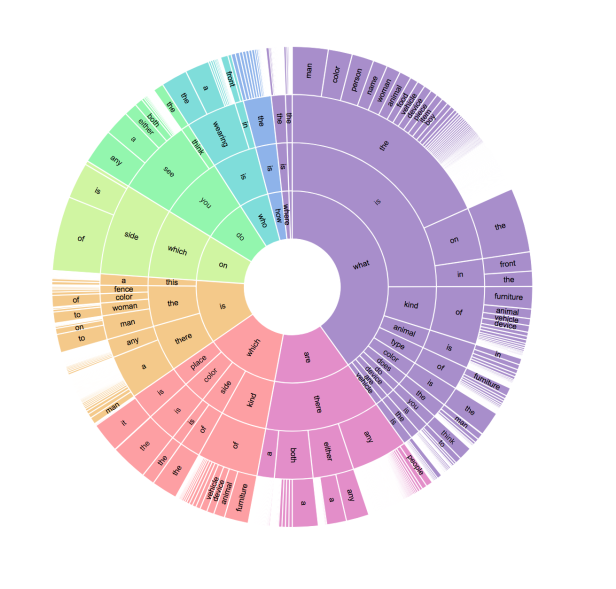

My figure is super different:

* `what` is much less present
* `what is the` is followed most often by `color` instead of `man`
* `are` is also followed by `the` not only `there`
* `is` is followed by 4.5x as many `the` as `there`
* `is` is also followed by `that`, not only `there`, `the`, `this`
* there is `on which`
* ...

### Check whether it could be the data split

In [19]:
gqa_questions_balanced[(gqa_questions_balanced['question_text'].str.contains('Are the ')) & (gqa_questions_balanced['datasplit'] == 'train')].head(5)

questionID                                    question_text  \
131056308  131056308                        Are the kids on the rock?   
16378562    16378562          Are the ripe bananas above a newspaper?   
10138194    10138194                 Are the feathers yellow or blue?   
06269159    06269159                         Are the fries on a tray?   
18207337    18207337  Are the people in the field standing by a lamb?   

          answer_text semantic_type structural_type detailed_type datasplit  \
131056308         yes           rel          verify     relVerify     train   
16378562          yes           rel          verify     relVerify     train   
10138194       yellow          attr          choose    chooseAttr     train   
06269159          yes           rel          verify     relVerify     train   
18207337           no           rel          verify   relVerifyCo     train   

          global_question_group  local_question_group  \
131056308                  None      13-children_rock   
16378562                   None  13-bananas_newspaper   
10138194                  color    10c-feathers_color   
06269159                   None         13-fries_tray   
18207337                   None        13-people_lamb   

          local_question_group_clean question_length composition_len_semantic  \
131056308              children_rock               6                        2   
16378562           bananas_newspaper               7                        3   
10138194              feathers_color               6                        2   
06269159                  fries_tray               6                        2   
18207337                 people_lamb              10                        3   

                  first_four_words  
131056308          Are the kids on  
16378562      Are the ripe bananas  
10138194   Are the feathers yellow  
06269159          Are the fries on  
18207337         Are the people in

In [20]:
gqa_questions_balanced[(gqa_questions_balanced['question_text'].str.contains('Are the ')) & (gqa_questions_balanced['datasplit'] == 'val')].head(5)

questionID                                      question_text  \
08203407   08203407  Are the curtains to the right or to the left o...   
12661982   12661982                     Are the shorts black or green?   
14311593   14311593            Are the letters on the bag on the left?   
00457871   00457871                        Are the glasses on a couch?   
01109297   01109297  Are the glasses in the bottom part or in the top?   

         answer_text semantic_type structural_type   detailed_type datasplit  \
08203407       right           rel          choose      relChooser       val   
12661982       black          attr          choose      chooseAttr       val   
14311593         yes           rel          verify       relVerify       val   
00457871          no           rel          verify     relVerifyCo       val   
01109297         top          attr          choose  positionChoose       val   

         global_question_group   local_question_group  \
08203407                  None     13-pillow_curtains   
12661982                 color       10c-shorts_color   
14311593                  None         13-letters_bag   
00457871                  None       13-glasses_couch   
01109297                  None  10c-glasses_vposition   

         local_question_group_clean question_length composition_len_semantic  \
08203407            pillow_curtains              14                        3   
12661982               shorts_color               6                        2   
14311593                letters_bag               9                        2   
00457871              glasses_couch               6                        2   
01109297          glasses_vposition              11                        2   

              first_four_words  
08203407   Are the curtains to  
12661982  Are the shorts black  
14311593    Are the letters on  
00457871    Are the glasses on  
01109297    Are the glasses in

### Testing the Sunburst Calculations

In [40]:
# it's easy to check all the counts with full four words
for index, row in sunburst_df.iterrows():
    if row['fourth_words'] != "null":
        reconstructed_question = " ".join([row['first_words'].capitalize(), row['second_words'], row['third_words'], row['fourth_words']])
        reconstructed_question_mark = reconstructed_question+"?"
        if reconstructed_question in word_counts['first_four_words'].values:
            idx = word_counts['first_four_words'].tolist().index(reconstructed_question)
            if word_counts.iloc[idx]['count'] != row['count']:
                print(f"Count mismatch for {reconstructed_question}: {word_counts.iloc[idx]['count']} vs. {row['count']}")
        elif reconstructed_question_mark in word_counts['first_four_words'].values:
            idx = word_counts['first_four_words'].tolist().index(reconstructed_question_mark)
            if word_counts.iloc[idx]['count'] != row['count']:
                print(f"Count mismatch for {reconstructed_question}: {word_counts.iloc[idx]['count']} vs. {row['count']}")
        else:
            print(f"Question {reconstructed_question} not found in the word_counts dataframe")

Count mismatch for How is the weather: 208 vs. 1550
Question Is it outdoors  not found in the word_counts dataframe
Question Is it indoors  not found in the word_counts dataframe
Question Who is standing  not found in the word_counts dataframe
Question Who is sitting  not found in the word_counts dataframe
Count mismatch for Where is the man: 425 vs. 621
Question How's the weather  not found in the word_counts dataframe
Question Who is playing  not found in the word_counts dataframe
Question Who is walking  not found in the word_counts dataframe
Count mismatch for What place is this: 139 vs. 361
Count mismatch for What's the man holding: 2 vs. 296
Question Where is it  not found in the word_counts dataframe
Count mismatch for Where is the woman: 127 vs. 213
Count mismatch for What is he holding: 3 vs. 189
Count mismatch for What animal is standing: 580 vs. 187
Count mismatch for Where is the snow: 8 vs. 182
Question Where is this  not found in the word_counts dataframe
Question Who is 

In [61]:
# check: whether `what is the` is followed most often by `color` (supplemental) or `man`
print("Is 'color' more frequent than 'man' for 'what is the'?")
print(f"What is the is followed by 'color' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('What is the color |What is the color?', regex=True)]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'What') &  (sunburst_df_reduced['second_words'] == 'is') & (sunburst_df_reduced['third_words'] == 'the') & (sunburst_df_reduced['fourth_words'] == 'color')]['count'].values[0]} questions.")
print(f"What is the is followed by 'man' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('What is the man |What is the man?', regex=True)]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'What') &  (sunburst_df_reduced['second_words'] == 'is') & (sunburst_df_reduced['third_words'] == 'the') & (sunburst_df_reduced['fourth_words'] == 'man')]['count'].values[0]} questions.")

# check: whether all `are` are followed by `there` or also by `the`
print("Is there also 'the' after 'are'?")
print(f"Are is followed by 'there' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Are there ')]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'Are') &  (sunburst_df_reduced['second_words'] == 'there')]['count'].values[0]} questions.")
print(f"Are is followed by 'the' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Are the ')]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'Are') &  (sunburst_df_reduced['second_words'] == 'the')]['count'].values[0]} questions.")

# check: whether `is` is followed by 4.5x as many `the` as `there`, or that `there` is more frequent
print("Is 'the' more frequent than 'there' for 'is'?")
print(f"Is is followed by 'the' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Is the ')]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'Is') &  (sunburst_df_reduced['second_words'] == 'the')]['count'].values[0]} questions.")
print(f"Is is followed by 'there' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Is there ')]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'Is') &  (sunburst_df_reduced['second_words'] == 'there')]['count'].values[0]} questions.")

# check: whether `is` is also followed by `that`
print("Is there also 'that' also after 'is'?")
print(f"Is is followed by 'that' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('Is that ')]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'Is') &  (sunburst_df_reduced['second_words'] == 'that')]['count'].values[0]} questions.")

# check: whether there is `On which`
print("Is there 'On which'?")
print(f"Is there 'On which' in {gqa_questions_balanced[gqa_questions_balanced['question_text'].str.contains('On which ')]['questionID'].count()} questions, and the sunburst says {sunburst_df_reduced[(sunburst_df_reduced['first_words'] == 'On') &  (sunburst_df_reduced['second_words'] == 'which')]['count'].values[0]} questions.")

Is 'color' more frequent than 'man' for 'what is the'?
What is the is followed by 'color' in 13079 questions, and the sunburst says 13055 questions.
What is the is followed by 'man' in 10129 questions, and the sunburst says 9690 questions.
Is there also 'the' after 'are'?
Are is followed by 'there' in 106116 questions, and the sunburst says 1176 questions.
Are is followed by 'the' in 18999 questions, and the sunburst says 18999 questions.
Is 'the' more frequent than 'there' for 'is'?
Is is followed by 'the' in 184796 questions, and the sunburst says 1364 questions.
Is is followed by 'there' in 42347 questions, and the sunburst says 1121 questions.
Is there also 'that' also after 'is'?
Is is followed by 'that' in 5114 questions, and the sunburst says 1213 questions.
Is there 'On which'?
Is there 'On which' in 41645 questions, and the sunburst says 1369 questions.


Okay, where are the differences in my code?

In [41]:
# plausibilty check whether the above is also in the gqa_train_balanced_questions w/o any modifications
problematic_keys = list(gqa_questions_balanced[(gqa_questions_balanced['question_text'].str.contains('Are the ')) & (gqa_questions_balanced['datasplit'] == 'val')]['questionID'])
for key, item in gqa_val_balanced_questions.items():
    if key in problematic_keys:
        if not item['question'] == gqa_questions_balanced.loc[key]['question_text']:
            print(f"There is sth with {key} and {item['question']} and {gqa_questions_balanced.loc[key]['question_text']}")
print("DONE")

DONE


My transformations did nothing stupid I guess!

## Reproducing figure 8: Ratio Types (ReadMe: 2.)

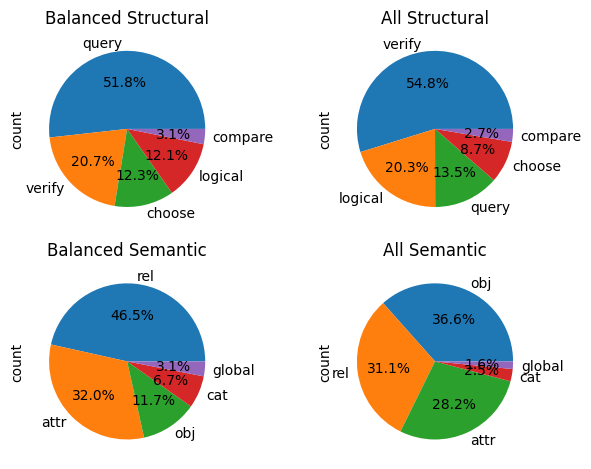

In [63]:
# visualize the type distributions
# with a 2x2 grid of pie charts, on the y-axis the type (structural, semantic) and on the x-axis the dataset (balanced, all)
fig, axs = plt.subplots(2, 2)

gqa_questions_balanced['structural_type'].value_counts().plot.pie(ax=axs[0,0],autopct='%1.1f%%')
axs[0,0].set_title('Balanced Structural')

gqa_questions_balanced['semantic_type'].value_counts().plot.pie(ax=axs[1,0],autopct='%1.1f%%')
axs[1,0].set_title('Balanced Semantic')

gqa_questions_all['structural_type'].value_counts().plot.pie(ax=axs[0,1],autopct='%1.1f%%')
axs[0,1].set_title('All Structural')

gqa_questions_all['semantic_type'].value_counts().plot.pie(ax=axs[1,1],autopct='%1.1f%%')
axs[1,1].set_title('All Semantic')

plt.tight_layout()
# write to file
plt.savefig('results/fig8_GQA_types.png')
plt.show()

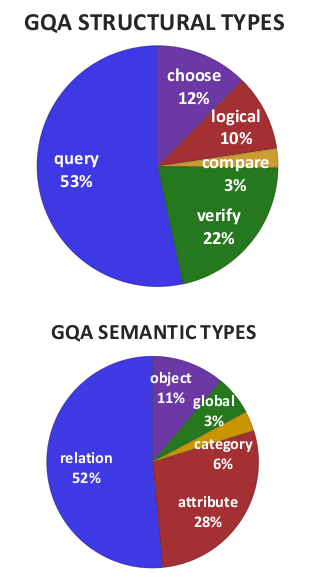

structural
* query: $51.7 \% != 53 \%$
* verify: $20.7 \% != 22 \%$
* logical: $12.1 \% != 10 \%$

semantic:
* relation: $46.6 \% != 52 \%$
* object: $11.8 \% != 11 \%$
* category: $6.7 \% != 6 \%$
* attribute: $31.9 \% != 28 \%$

Maybe it changes significantly if a different datasplit is used (only for balanced):

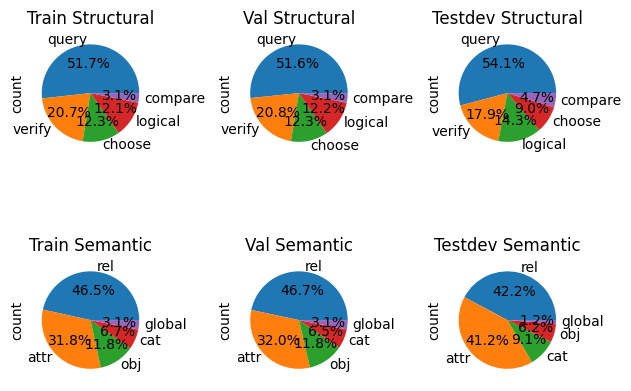

In [64]:
# visualize the type distributions, for balanced only
# with a 3x2 grid of pie charts, on the y-axis the type (structural, semantic) and on the x-axis the data split (train, val, testdev)
fig, axs = plt.subplots(2, 3)

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'train']['structural_type'].value_counts().plot.pie(ax=axs[0,0],autopct='%1.1f%%')
axs[0,0].set_title('Train Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'train']['semantic_type'].value_counts().plot.pie(ax=axs[1,0],autopct='%1.1f%%')
axs[1,0].set_title('Train Semantic')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'val']['structural_type'].value_counts().plot.pie(ax=axs[0,1],autopct='%1.1f%%')
axs[0,1].set_title('Val Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'val']['semantic_type'].value_counts().plot.pie(ax=axs[1,1],autopct='%1.1f%%')
axs[1,1].set_title('Val Semantic')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'testdev']['structural_type'].value_counts().plot.pie(ax=axs[0,2],autopct='%1.1f%%')
axs[0,2].set_title('Testdev Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'testdev']['semantic_type'].value_counts().plot.pie(ax=axs[1,2],autopct='%1.1f%%')
axs[1,2].set_title('Testdev Semantic')

plt.tight_layout()
plt.show()

There seems to be quiet a bit of variance in it, but is it really enough to change the picture if the train data split has much more samples?

## Reproducing table 2: Function Catalog (ReadMe: 3.)

Here, probably the question as classified by its answer type is referenced?!

In [74]:
gqa_question_stats_table = gqa_questions_balanced[['detailed_type', 'semantic_type', 'structural_type']].drop_duplicates()

# sort values by semantic_type in the order: 'global', 'attribute', 'category', 'relation', 'object'
print(f"The unique values of the semantic_type are {gqa_question_stats_table['semantic_type'].unique()}")
gqa_question_stats_table['semantic_type'] = pd.Categorical(gqa_question_stats_table['semantic_type'], categories=['global', 'attr', 'cat', 'rel', 'obj'], ordered=True)
gqa_question_stats_table = gqa_question_stats_table.sort_values(by='semantic_type')

# write to file
gqa_question_stats_table.to_csv('results/tab2_functions_catalog.csv', index=False)

gqa_question_stats_table

The unique values of the semantic_type are ['attr' 'rel' 'obj' 'cat' 'global']


detailed_type semantic_type structural_type
15721838          weather        global           query
00895292   locationVerify        global          verify
06778809            place        global           query
05239949     placeVerifyC        global          verify
09330194  locationVerifyC        global          verify
...                   ...           ...             ...
00310543    verifyAttrAnd           obj         logical
1948030     existAttrNotC           obj          verify
09298162         existAnd           obj         logical
09245467       existThatC           obj          verify
18324280    existMaterial           obj          verify

[105 rows x 3 columns]

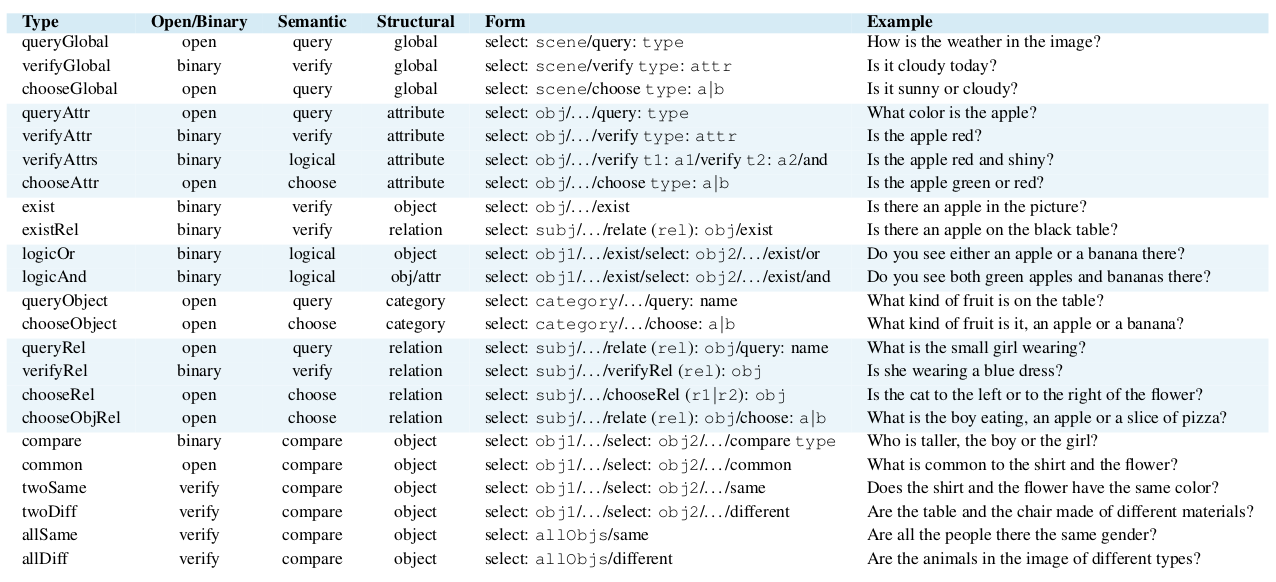

Clearly, `semantic` and `structural` is switched.

In [75]:
# search for the types from the table
function_catalog_in_paper = ['queryGlobal', 'verifyGlobal', 'chooseGlobal',
                             'queryAttr', 'verifyAttr', 'verifyAttrs', 'chooseAttr',
                             'exist', 'existRel',
                             'logicOr', 'logicAnd',
                             'queryObject', 'chooseObject',
                             'queryRel', 'verifyRel', 'chooseRel', 'chooseObjRel',
                             'compare', 'common', 'twoSame', 'twoDiff', 'allSame', 'allDiff']

gqa_question_stats_table[gqa_question_stats_table['detailed_type'].isin(function_catalog_in_paper)]

detailed_type semantic_type structural_type
02930152    verifyAttr          attr          verify
17320318   verifyAttrs          attr         logical
15736264    chooseAttr          attr          choose
0172015        twoSame          attr         compare
06620951         exist           obj          verify

This is also super different and unclear which field the `type` from the paper should be.

In [ ]:
gqa_question_stats_table[gqa_question_stats_table['structural_type'] == 'compare'].sort_values(by='semantic_type')

detailed_type semantic_type structural_type
02212741       twoDifferentC          attr         compare
0172015              twoSame          attr         compare
03839467         diffAnimals          attr         compare
13761988        twoDifferent          attr         compare
15867119        sameAnimalsC          attr         compare
09330195    twoSameMaterialC          attr         compare
09680288            twoSameC          attr         compare
00226745           twoCommon          attr         compare
00299606        diffAnimalsC          attr         compare
051001757        sameAnimals          attr         compare
06563513   comparativeChoose          attr         compare
1469734           sameGender          attr         compare
0692996      twoSameMaterial          attr         compare
11187391         sameGenderC          attr         compare
121046176         diffGender          attr         compare

* where in the table is `compare` <-> `attr`? 
* Where is `compare` to `object`?
* ...

On a similar note, it's unclear what `fig. 7` plots:

In [1]:
# make a pie diagram with all values of detailed_type in gqa_question_stats with plotly and interactive
fig = px.pie(gqa_questions_balanced, names='detailed_type')

# the legend should only show the first 20 entries and be on the left
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=False, legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig.write_html('results/fig7b_question_type_pie.html')
# fig.show()  # too big to show in the notebook

NameError: name 'px' is not defined

## Reproducing figure 10: Dataset Balancing (ReadMe: 4.)

In [81]:
# unique values
global_question_group_set = set(gqa_questions_balanced['global_question_group'])
local_question_group_clean_set = set(gqa_questions_balanced['local_question_group_clean'])

print(f"There are {len(list(global_question_group_set))} global question groups")
print(f"There are {len(list(set(gqa_questions_balanced['local_question_group'])))} local question groups, after cleaning there are {len(list(local_question_group_clean_set))} local question groups")

There are 117 global question groups
There are 148149 local question groups, after cleaning there are 116145 local question groups


In [91]:
global_question_types_in_paper = ['length', 'height', 'size', 'fast food', 'aircraft', 'bag', 'watercraft', 'person', 'room', 'weather', 'appliance', 'baked good',
                                  'thing', 'road', 'vehicle', 'fruit', 'place', 'dessert', 'urban environment', 'pose', 'furniture', 'activity', 'animal', 'food',
                                  'color', 'vegetable', 'material', 'clothing', 'device', 'object']
local_question_types_in_paper = ['car_vposition', 'hair_length', 'location', 'girl_age', 'bottle_material', 'window_size', 'woman_hposition', 'grass_height', 
                                 'shirt_pattern', 'clock', 'floor_cleanliness', 'man', 'location_outdoors', 'car_modernity', 'plate_shape', 'sky_color', 'dog_color',
                                 'man_woman', 'water_state', 'table_material', 'apple_color', 'pizza_cooking', 'ground_type', 'fence_material', 'sky_weather',
                                 'man_sportActivity', 'shirt_color','trees_leafy', 'man_pose', 'man_activity']

In [93]:
# check whether the reported answer types are in the respective set
for answer in global_question_types_in_paper:
    if answer not in global_question_group_set:
        print(f"{answer} is not in the global set")

# otherwise there are problems in the loop
if None in local_question_group_clean_set:
    local_question_group_clean_set.remove(None)

for answer in local_question_types_in_paper:
    if answer not in local_question_group_clean_set:
        print(f"{answer} is not in the local set")
        partially = []
        part1, part2 = answer.split('_')
        for answer2 in local_question_group_clean_set:
            part_2 = answer2.split('_')
            if len(part_2) >= 2:
                part1_2, part2_2 = part_2[0], part_2[1]
            else:
                part1_2, part2_2 = part_2[0], ""
            if answer in answer2:
                print(f"{answer} is in {answer2}")
            elif part1 == part1_2:
                partially.append(answer2)
            elif part2 == part2_2:
                partially.append(answer2)
        print(f"Partially: {partially}")

car_modernity is not in the local set
Partially: ['car_wall', 'car_polo shirt', 'car_painting', 'car_chair', 'car_light bulb', 'car_sticker', 'car_stop sign', 'car_pine tree', 'car_ski', 'car_dishwasher', 'car_luggage', 'car_desk', 'car_under', 'car_parked behind', 'car_length', 'car_pizza slice', 'car_maroon', 'car_taxi', 'car_truck', 'car_bags', 'car_leaving', 'car_pot', 'car_below', 'car_skirt', 'car_sitting in', 'car_standing on', 'car_dress', 'car_tone', 'car_yellow', 'car_flower pot', 'car_bull', 'car_cake', 'car_cleanliness', 'car_short', 'car_tag', 'car_light bulbs', 'car_empty', 'car_traffic light', 'car_poster', 'car_folding chair', 'car_bottom', 'car_goal', 'car_kites', 'car_lying on', 'car_chimney', 'car_pizza', 'car_gold', 'car_filled with', 'car_between', 'car_swan', 'car_running in', 'car_fatness', 'car_covered by', 'car_vending machine', 'car_vest', 'car_purse', 'car_boy', 'car_bikes', 'car_castle', 'car_display', 'car_car', 'car_closed', 'car_mouse pad', 'car_to the ri

Two answer groups of the figure are not part of dataset anymore. But `car_modernity` -> `car_modern` probably though.

In [94]:
# fix for further processing
local_question_types_in_paper.remove("ground_type")
local_question_types_in_paper.remove("car_modernity")
local_question_types_in_paper.append("car_modern")

### The figure itself

In [96]:
def group_distribution(dataframe, question_group_type, selected_types, gqa_datasplit="balanced", plot=True):
    """
    For a given question_group, calculate the value count of the selected_types.
    Plots the distribution in a stacked bar plot.

    :param dataframe: the dataframe to be used
    :param question_group_type: the question group to be used: "local_question_group_clean" or "global_question_group"
    :param selected_types: the types to be used, has to be in accordance with the question_group
    :param gqa_datasplit: the datasplit used: "all" or "balanced", has to be in accordance with the dataframe (only needed for the title of the plot)
    :param plot: whether to plot the distribution
    """
    column_nos = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']
    # insert the question_group as the first element of columns
    columns = [question_group_type] + column_nos

    # create a dataframe with the necessary columns
    question_group_distribution = pd.DataFrame(columns=columns, index=selected_types)

    # calculate the value count for each type of the selected_types
    for question_gr in selected_types:
        value_counts = dataframe[dataframe[question_group_type] == question_gr]['answer_text'].value_counts()[:10]

        # normalize the value counts
        value_counts = value_counts / value_counts.sum()

        # fill up the value counts with 0, if its shape is less than 10
        if len(value_counts) < 10:
            missing_values = pd.Series([0.] * (10 - len(value_counts)), index=[f'filler_{i+1}' for i in range(10 - len(value_counts))])
            value_counts = pd.concat([value_counts, missing_values])

        # add to the big dataframe
        question_group_distribution.loc[question_gr, column_nos] = value_counts.values
        question_group_distribution.loc[question_gr, 'question_group'] = question_gr

    # do some post-processing that plotting works well
    question_group_distribution.sort_values(by='1st', ascending=False, inplace=True)
    question_group_distribution.reset_index(drop=True, inplace=True)

    if plot:
        question_group_distribution_long = pd.melt(question_group_distribution, id_vars='question_group', value_vars=column_nos, var_name='Rank', value_name='Relative Frequency')
        fig = px.bar(question_group_distribution_long, x="question_group", y="Relative Frequency", color='Rank', title=f"{gqa_datasplit} dataset {question_group_type} balancing")
        fig.write_html(f'results/fig10_dataset_balancing_{gqa_datasplit}_{question_group_type}.html')
        fig.show()

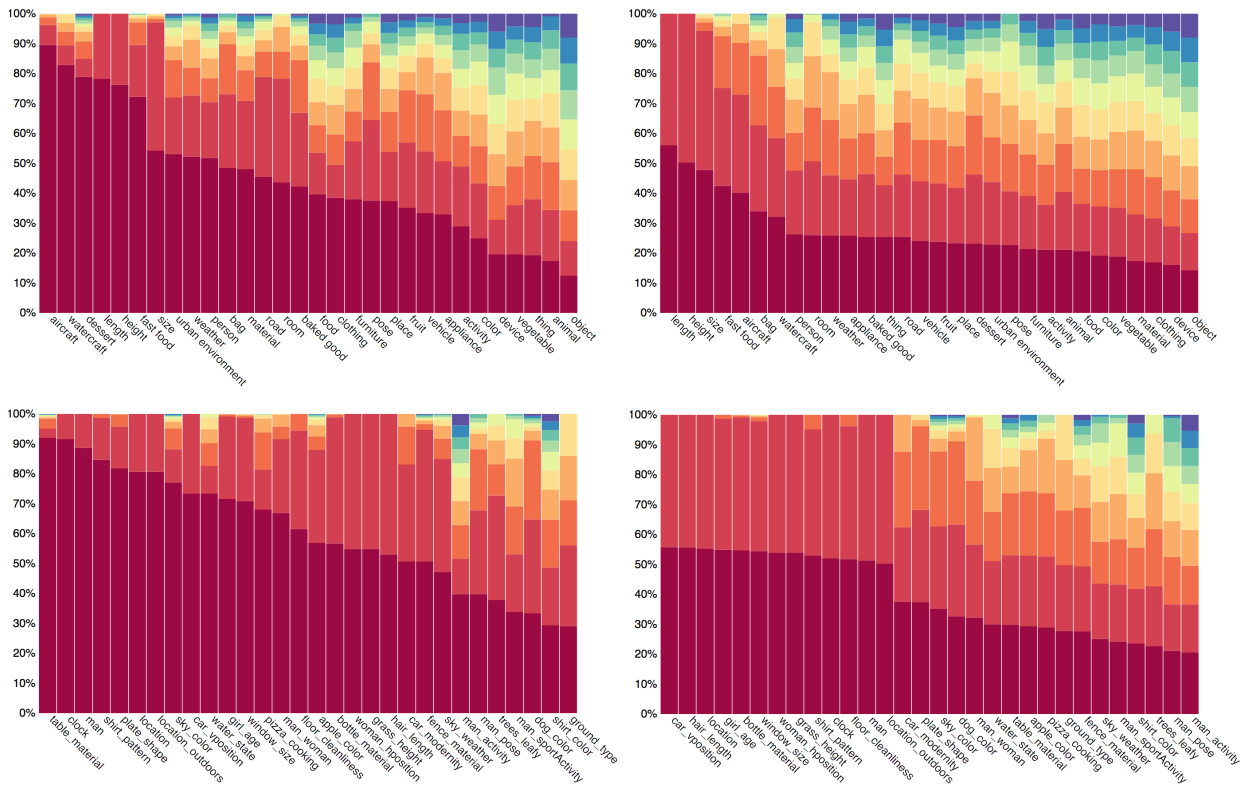

"The left side shows the distribution before any balancing. We show the top 10 answers for a selection of question groups, where the column height corresponds to the relative frequency of each answer. The top row shows global question groups such as color questions, questions about animals, etc. while the bottom row shows local ones e.g. apple-color, table-material etc (section 3.3, main paper)."

In [97]:
group_distribution(gqa_questions_balanced, "local_question_group_clean", local_question_types_in_paper, gqa_datasplit="balanced", plot=True)

* vastly different for `man`, `car_modern`, and a lot of other labels

In [98]:
group_distribution(gqa_questions_balanced, "global_question_group", global_question_types_in_paper, gqa_datasplit="balanced", plot=True)

* `bag` (6 -> 16) is somewhere totally different, a lot of others (`room`, `weather`) also changing places... 
* `fast food` and `aircraft` are now basically on the same most frequent levels. (...) but the general picture is similar.

In [99]:
group_distribution(gqa_questions_all, "local_question_group_clean", local_question_types_in_paper, gqa_datasplit="all", plot=True)

* there is no balancing possible, if `man` has no second most frequent answer

In [100]:
group_distribution(gqa_questions_all, "global_question_group", global_question_types_in_paper, gqa_datasplit="all", plot=True)

* `material` nearly perfectly switched with `clothing`, `applicance` with `vehicle`.

### Testing the results

## Reproducing figure 13: Semantic Steps (ReadMe: 5.)

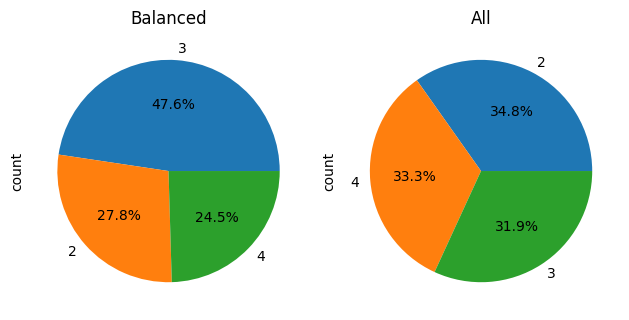

In [102]:
# summarize all values of 4 and above
gqa_semantic_steps_pie_balanced = gqa_questions_balanced['composition_len_semantic']
gqa_semantic_steps_pie_balanced[gqa_semantic_steps_pie_balanced >= 4] = 4

gqa_semantic_steps_pie_all = gqa_questions_all['composition_len_semantic']
gqa_semantic_steps_pie_all[gqa_semantic_steps_pie_all >= 4] = 4

# plot the pie charts
fig, axs = plt.subplots(1, 2)

gqa_semantic_steps_pie_balanced.value_counts().plot.pie(ax=axs[0],autopct='%1.1f%%')
axs[0].set_title('Balanced')

gqa_semantic_steps_pie_all.value_counts().plot.pie(ax=axs[1],autopct='%1.1f%%')
axs[1].set_title('All')

plt.tight_layout()
plt.savefig('results/fig13_semantic_steps.png')

* there are no questions with a field length of $1$

## Reproducing table 3: Comparison of VQA and GQA (ReadMe: 6.)

In [109]:
# caluclate the mean length and std of the questions
mean_length = gqa_questions_balanced['question_length'].mean()
mean_length_wo_test = gqa_questions_balanced[gqa_questions_balanced['datasplit'] != 'testdev']['question_length'].mean()
std_length = gqa_questions_balanced['question_length'].std()
std_length_wo_test = gqa_questions_balanced[gqa_questions_balanced['datasplit'] != 'testdev']['question_length'].std()
print(f"Question length: {mean_length:.2f} +/- {std_length:.2f}")
print(f"Question length (without testdev): {mean_length_wo_test:.2f} +/- {std_length_wo_test:.2f}")

# print(f"Compositional Questions (>0): {len(gqa_questions_balanced[gqa_questions_balanced['composition_len_semantic'] > 0]) / len(gqa_questions_balanced):.2f}")
# print(f"Compositional Questions (>1): {len(gqa_questions_balanced[gqa_questions_balanced['composition_len_semantic'] > 1]) / len(gqa_questions_balanced):.2f}")
# print(f"Composition length: {gqa_questions_balanced['composition_len_semantic'].mean():.2f} +/- {gqa_questions_balanced['composition_len_semantic'].std():.2f}")

# calculate the ratio of relation, spatial, logical, comparative
gqa_questions_balanced['structural_type'].value_counts(normalize=True)

Question length: 8.79 +/- 3.61
Question length (without testdev): 8.79 +/- 3.62


structural_type
query      0.517565
verify     0.206639
choose     0.123005
logical    0.121297
compare    0.031494
Name: proportion, dtype: float64

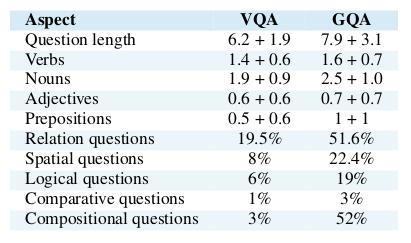

* the question length and the std is quiet different!
* how does calculating compositional questions work?
* Spatial == `verify`?
* less `logical` questions

In an earlier version of the paper, this table was significantly longer and included the following:

In [110]:
# calculate the ratio of the where-questions and the who-questions
where_questions = gqa_questions_balanced['question_text'].apply(lambda x: True if 'where' in x.lower().split()[0] else False)
print(f"The ratio of where-questions is {where_questions.sum() / len(where_questions) *100:.3f}%")
who_questions = gqa_questions_balanced['question_text'].apply(lambda x: True if 'who' in x.lower().split()[0] else False)
print(f"The ratio of who-questions is {who_questions.sum() / len(who_questions) *100:.3f}%")

print(f"Short Questions <= 5 words: {len(gqa_questions_balanced[gqa_questions_balanced['question_length'] <= 5]) / len(gqa_questions_balanced):.2f}")

The ratio of where-questions is 1.395%
The ratio of who-questions is 5.690%
Short Questions <= 5 words: 0.19
